# Setup

Import required libraries including Tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import random
import os
from numpy.random import seed

random.seed(42)
os.environ['PYTHONASHSEED'] = '42' 
seed(42)
tf.random.set_seed(42)

Check for Colab's GPU

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Check connected GPU type

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  9 16:58:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Mount storage from Google Drive

In [4]:
from google.colab import drive
drive.mount('p2')

Mounted at p2


# Dataset

In [5]:
df = pd.read_csv('/content/p2/MyDrive/p2/data/preprocessed_500k_imba.csv', dtype={'text': 'str', 'processed_text': 'str', 'stars': float})
df.fillna('', inplace=True)
df.head()

,text,stars,processed_text
0,Three words: Damn good pastries.\n\nA few mor...,4.0,three word damn good pastry word probably best...
1,Easily one of the worst Red Robin locations. T...,0.0,easily one worst red robin location food delic...
2,Maybe I am just spoiled with good Mexican food...,1.0,maybe spoiled good mexican food growing san di...
3,This Wildflower is always kept clean and the e...,4.0,wildflower always kept clean employee nice pot...
4,Favorite bibimbap in the valley! They also hav...,4.0,favorite bibimbap valley also korean fixing sm...


# Preprocessing

One-hot encoding of star labels

In [6]:
y = tf.keras.utils.to_categorical(df["stars"].values, num_classes=5)
y

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

Split dataset in stratified manner into train, validation and test set with proportion of 6:2:2

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.25, 
    stratify=y_train, 
    random_state=42
)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(300000,)
(100000,)
(100000,)


Check the processed text and class

In [8]:
for i in range(5):
    print(x_train.iloc[i])
    print(y_train[i])
    
for i in range(5):
    print(x_val.iloc[i])
    print(y_val[i])

basically everything menu !had one thing !enjoy crab puppy best twist original hush puppy good vibe way around
[0. 0. 0. 0. 1.]
awesome middle eastern take hot sauce incredible love sandwich rock dish
[0. 0. 0. 0. 1.]
!rude completed order 10 minute lady drive arguing customer store literally yelled another mic !hear proceeded talk bad customer front 8 customer store !be back crew seems toxic wonder would act gm food beverage would expect far concerned update got new staff management gotten much better seems manager working hard customer service night day different glad see people striving better
[0. 0. 0. 1. 0.]
favorite dish tom kha shrimp soup order rice go along soup large enough serving meal pineapple fried rice chock full goody raisin cashew pineapple prefer shrimp meat addition tried chicken satay thai restaurant hand favorite archi would offer curry puff would !need go anywhere else best thai tea lunch special provide enough food although would like able choose soup come soup d

Tokenize the text with max vocabulary of 100,000

In [9]:
MAX_VOCAB_SIZE = 100000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(np.concatenate((x_train, x_val, x_test), axis=0))

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

for i in range(3):
  print(x_train[i])

[759, 75, 21, 532, 9, 60, 237, 346, 2959, 23, 1821, 881, 3296, 2959, 3, 621, 67, 97]
[133, 743, 2130, 83, 108, 38, 691, 31, 81, 853, 44]
[502, 4670, 15, 215, 73, 497, 450, 4805, 120, 474, 585, 3673, 123, 7307, 856, 1935, 764, 99, 120, 325, 602, 120, 474, 196, 11, 2292, 431, 13885, 1421, 7, 1998, 3925, 1, 1249, 7, 374, 257, 2170, 1225, 20, 106, 42, 767, 991, 47, 59, 431, 220, 529, 252, 120, 6, 65, 80, 158, 524, 129, 54, 15787, 59]


Show the top 20 most frequent tokens

In [10]:
i = 0

for word in tokenizer.word_index:
    print(f"{word} : {tokenizer.word_index[word]}")
    i += 1
    if i >= 20:
        break

food : 1
place : 2
good : 3
great : 4
time : 5
service : 6
would : 7
like : 8
one : 9
get : 10
back : 11
go : 12
really : 13
restaurant : 14
order : 15
ordered : 16
u : 17
also : 18
chicken : 19
got : 20


The actual token size in the corpus

In [11]:
vocab_size

143134

Pad the tokens to fixed length of 100

In [12]:
max_length = 100

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=max_length)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=max_length)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, padding='post', maxlen=max_length)

x_train[:5, :]

array([[  759,    75,    21,   532,     9,    60,   237,   346,  2959,
           23,  1821,   881,  3296,  2959,     3,   621,    67,    97,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  133,   743,  2130,    83,   108,    38,   691,    31,    81,
          853,    44,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

Populate initial word embedding weights based on pre-trained GloVe

In [13]:
embedding_dim = 100

def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = np.zeros((MAX_VOCAB_SIZE, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index and (word_index[word] < MAX_VOCAB_SIZE):
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_matrix = create_embedding_matrix(
    '/content/p2/MyDrive/p2/data/glove.6B.100d.txt',
    tokenizer.word_index,
    embedding_dim
)

print(embedding_matrix.shape)
embedding_matrix[:5]

(100000, 100)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

Calculate the percentage of vocabs found in GloVe and given initial weights

In [14]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / MAX_VOCAB_SIZE

0.56309

# Modeling

## Bidirectional LSTM

Build CNN-LSTM model

In [ ]:
from keras.layers import Bidirectional

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    Bidirectional(tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    )),
    Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

Show summary of model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10000000  
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 100)          30100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 100)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              2

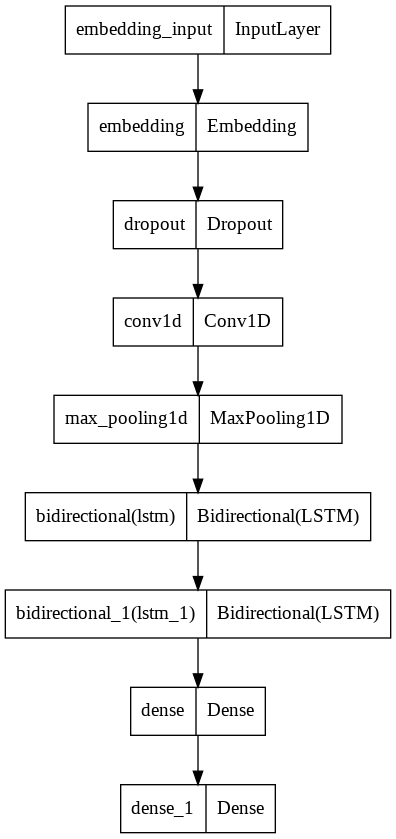

In [ ]:
tf.keras.utils.plot_model(model)

Compile model with loss function and metrics

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

Train model

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_bidirectional-lstm/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history = model.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1535s 162ms/step - loss: 0.9065 - accuracy: 0.6143 - val_loss: 0.8429 - val_accuracy: 0.6416
Epoch 2/8
9375/9375 [==============================] - 1460s 156ms/step - loss: 0.7899 - accuracy: 0.6609 - val_loss: 0.7966 - val_accuracy: 0.6593
Epoch 3/8
9375/9375 [==============================] - 1459s 156ms/step - loss: 0.7407 - accuracy: 0.6845 - val_loss: 0.7857 - val_accuracy: 0.6603
Epoch 4/8
9375/9375 [==============================] - 1499s 160ms/step - loss: 0.6993 - accuracy: 0.7052 - val_loss: 0.8059 - val_accuracy: 0.6550
Epoch 5/8
9375/9375 [==============================] - 1515s 162ms/step - loss: 0.6589 - accuracy: 0.7257 - val_loss: 0.8431 - val_accuracy: 0.6523
Epoch 5: early stopping


Evaluate model with val set

In [ ]:
model.load_weights(checkpoint_filepath)

y_pred = model.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 96s 30ms/step
              precision    recall  f1-score   support

           0     0.7076    0.8155    0.7577     11805
           1     0.5244    0.3664    0.4314      9287
           2     0.5224    0.5045    0.5133     13362
           3     0.5564    0.5957    0.5754     26144
           4     0.7865    0.7787    0.7826     39402

    accuracy                         0.6603    100000
   macro avg     0.6195    0.6122    0.6121    100000
weighted avg     0.6574    0.6603    0.6569    100000



array([[ 9627,  1326,   558,   143,   151],
       [ 2888,  3403,  2469,   417,   110],
       [  716,  1564,  6741,  3851,   490],
       [  170,   152,  2670, 15575,  7577],
       [  204,    44,   466,  8007, 30681]])

In [ ]:
y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 95s 30ms/step
              precision    recall  f1-score   support

           0     0.7098    0.8255    0.7633     11805
           1     0.5163    0.3505    0.4175      9287
           2     0.5196    0.5021    0.5107     13362
           3     0.5534    0.5980    0.5748     26145
           4     0.7874    0.7754    0.7814     39401

    accuracy                         0.6590    100000
   macro avg     0.6173    0.6103    0.6095    100000
weighted avg     0.6561    0.6590    0.6553    100000



array([[ 9745,  1262,   540,   127,   131],
       [ 2905,  3255,  2564,   437,   126],
       [  703,  1571,  6709,  3897,   482],
       [  185,   171,  2645, 15635,  7509],
       [  191,    46,   455,  8158, 30551]])

## Regularizers

#### Dropout, Recurrent Dropout = 0.4

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.4,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_2.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_dropout-04/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_2 = model_2.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 823s 88ms/step - loss: 0.9815 - accuracy: 0.5809 - val_loss: 0.8561 - val_accuracy: 0.6354
Epoch 2/8
9375/9375 [==============================] - 819s 87ms/step - loss: 0.8272 - accuracy: 0.6422 - val_loss: 0.8161 - val_accuracy: 0.6509
Epoch 3/8
9375/9375 [==============================] - 813s 87ms/step - loss: 0.7853 - accuracy: 0.6617 - val_loss: 0.7921 - val_accuracy: 0.6595
Epoch 4/8
9375/9375 [==============================] - 806s 86ms/step - loss: 0.7558 - accuracy: 0.6765 - val_loss: 0.7917 - val_accuracy: 0.6585
Epoch 5/8
9375/9375 [==============================] - 801s 85ms/step - loss: 0.7306 - accuracy: 0.6898 - val_loss: 0.8089 - val_accuracy: 0.6575
Epoch 5: early stopping


In [ ]:
model_2.load_weights(checkpoint_filepath)

y_pred = model_2.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 87s 23ms/step
              precision    recall  f1-score   support

           0     0.7450    0.7564    0.7507     11805
           1     0.5077    0.3950    0.4443      9287
           2     0.5162    0.4774    0.4961     13362
           3     0.5628    0.5576    0.5602     26144
           4     0.7618    0.8223    0.7909     39402

    accuracy                         0.6595    100000
   macro avg     0.6187    0.6017    0.6084    100000
weighted avg     0.6514    0.6595    0.6542    100000



array([[ 8929,  1822,   623,   165,   266],
       [ 2265,  3668,  2650,   507,   197],
       [  535,  1566,  6379,  4188,   694],
       [  121,   137,  2333, 14577,  8976],
       [  135,    32,   372,  6462, 32401]])

In [ ]:
y_pred = model_2.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 72s 23ms/step
              precision    recall  f1-score   support

           0     0.7467    0.7653    0.7559     11805
           1     0.4975    0.3727    0.4261      9287
           2     0.5129    0.4814    0.4966     13362
           3     0.5596    0.5551    0.5573     26145
           4     0.7624    0.8218    0.7909     39401

    accuracy                         0.6582    100000
   macro avg     0.6158    0.5992    0.6054    100000
weighted avg     0.6496    0.6582    0.6525    100000



array([[ 9034,  1774,   612,   161,   224],
       [ 2267,  3461,  2812,   545,   202],
       [  537,  1514,  6432,  4206,   673],
       [  123,   164,  2352, 14512,  8994],
       [  137,    44,   333,  6509, 32378]])

#### No dropout & recurrent dropout

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_3.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_no-dropout/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_3 = model_3.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 148s 15ms/step - loss: 0.9316 - accuracy: 0.6021 - val_loss: 0.8327 - val_accuracy: 0.6439
Epoch 2/8
9375/9375 [==============================] - 142s 15ms/step - loss: 0.7788 - accuracy: 0.6654 - val_loss: 0.8034 - val_accuracy: 0.6560
Epoch 3/8
9375/9375 [==============================] - 140s 15ms/step - loss: 0.7163 - accuracy: 0.6975 - val_loss: 0.8113 - val_accuracy: 0.6497
Epoch 4/8
9375/9375 [==============================] - 140s 15ms/step - loss: 0.6526 - accuracy: 0.7293 - val_loss: 0.8479 - val_accuracy: 0.6449
Epoch 4: early stopping


In [ ]:
model_3.load_weights(checkpoint_filepath)

y_pred = model_3.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 16s 5ms/step
              precision    recall  f1-score   support

           0     0.7314    0.7589    0.7449     11805
           1     0.4765    0.4971    0.4866      9287
           2     0.5312    0.4258    0.4727     13362
           3     0.5771    0.4952    0.5331     26144
           4     0.7433    0.8473    0.7919     39402

    accuracy                         0.6560    100000
   macro avg     0.6119    0.6049    0.6058    100000
weighted avg     0.6453    0.6560    0.6477    100000



array([[ 8959,  2079,   297,   114,   356],
       [ 2345,  4617,  1685,   409,   231],
       [  602,  2606,  5690,  3595,   869],
       [  172,   309,  2643, 12947, 10073],
       [  171,    79,   397,  5368, 33387]])

In [ ]:
y_pred = model_3.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 21s 7ms/step
              precision    recall  f1-score   support

           0     0.7333    0.7705    0.7514     11805
           1     0.4752    0.4819    0.4785      9287
           2     0.5332    0.4280    0.4749     13362
           3     0.5732    0.4965    0.5321     26145
           4     0.7431    0.8450    0.7907     39401

    accuracy                         0.6556    100000
   macro avg     0.6116    0.6044    0.6055    100000
weighted avg     0.6446    0.6556    0.6473    100000



array([[ 9096,  1982,   306,   123,   298],
       [ 2351,  4475,  1802,   402,   257],
       [  615,  2543,  5719,  3631,   854],
       [  190,   340,  2531, 12981, 10103],
       [  153,    78,   367,  5511, 33292]])

## Nodes

#### 64 & 32 LSTM nodes 

In [ ]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        64, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          10000000  
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 100)          30100     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 50, 100)          0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            42240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                      

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_4.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_less-lstm-nodes/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_4 = model_4.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1221s 129ms/step - loss: 0.9411 - accuracy: 0.5969 - val_loss: 0.8406 - val_accuracy: 0.6380
Epoch 2/8
9375/9375 [==============================] - 1208s 129ms/step - loss: 0.7999 - accuracy: 0.6544 - val_loss: 0.8021 - val_accuracy: 0.6533
Epoch 3/8
9375/9375 [==============================] - 1200s 128ms/step - loss: 0.7532 - accuracy: 0.6778 - val_loss: 0.7943 - val_accuracy: 0.6557
Epoch 4/8
9375/9375 [==============================] - 1205s 129ms/step - loss: 0.7130 - accuracy: 0.6985 - val_loss: 0.8077 - val_accuracy: 0.6501
Epoch 5/8
9375/9375 [==============================] - 1207s 129ms/step - loss: 0.6772 - accuracy: 0.7179 - val_loss: 0.8318 - val_accuracy: 0.6507
Epoch 5: early stopping


In [ ]:
model_4.load_weights(checkpoint_filepath)

y_pred = model_4.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 75s 24ms/step
              precision    recall  f1-score   support

           0     0.7268    0.7843    0.7545     11805
           1     0.5071    0.4205    0.4598      9287
           2     0.5081    0.5043    0.5062     13362
           3     0.5524    0.5780    0.5649     26144
           4     0.7847    0.7756    0.7801     39402

    accuracy                         0.6557    100000
   macro avg     0.6158    0.6125    0.6131    100000
weighted avg     0.6544    0.6557    0.6545    100000



array([[ 9259,  1698,   537,   141,   170],
       [ 2515,  3905,  2337,   389,   141],
       [  628,  1861,  6739,  3646,   488],
       [  159,   181,  3108, 15112,  7584],
       [  178,    55,   543,  8067, 30559]])

In [ ]:
y_pred = model_4.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 80s 25ms/step
              precision    recall  f1-score   support

           0     0.7251    0.7917    0.7569     11805
           1     0.4989    0.3992    0.4435      9287
           2     0.5082    0.5052    0.5067     13362
           3     0.5500    0.5808    0.5650     26145
           4     0.7842    0.7720    0.7781     39401

    accuracy                         0.6541    100000
   macro avg     0.6133    0.6098    0.6100    100000
weighted avg     0.6526    0.6541    0.6525    100000



array([[ 9346,  1660,   514,   116,   169],
       [ 2532,  3707,  2504,   407,   137],
       [  641,  1813,  6751,  3653,   504],
       [  182,   196,  3021, 15184,  7562],
       [  188,    54,   495,  8245, 30419]])

#### 50 & 5 Dense nodes

In [ ]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_5.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_less-dense-nodes/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_5 = model_5.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1218s 129ms/step - loss: 0.9424 - accuracy: 0.5964 - val_loss: 0.8438 - val_accuracy: 0.6375
Epoch 2/8
9375/9375 [==============================] - 1193s 127ms/step - loss: 0.7997 - accuracy: 0.6552 - val_loss: 0.8054 - val_accuracy: 0.6549
Epoch 3/8
9375/9375 [==============================] - 1190s 127ms/step - loss: 0.7501 - accuracy: 0.6789 - val_loss: 0.7896 - val_accuracy: 0.6607
Epoch 4/8
9375/9375 [==============================] - 1191s 127ms/step - loss: 0.7102 - accuracy: 0.6990 - val_loss: 0.8067 - val_accuracy: 0.6539
Epoch 5/8
9375/9375 [==============================] - 1190s 127ms/step - loss: 0.6726 - accuracy: 0.7188 - val_loss: 0.8399 - val_accuracy: 0.6543
Epoch 5: early stopping


In [ ]:
model_5.load_weights(checkpoint_filepath)

y_pred = model_5.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 97s 30ms/step
              precision    recall  f1-score   support

           0     0.7117    0.8036    0.7549     11805
           1     0.5267    0.3517    0.4217      9287
           2     0.5178    0.5115    0.5146     13362
           3     0.5601    0.5897    0.5745     26144
           4     0.7816    0.7884    0.7850     39402

    accuracy                         0.6607    100000
   macro avg     0.6196    0.6090    0.6101    100000
weighted avg     0.6565    0.6607    0.6565    100000



array([[ 9486,  1406,   587,   142,   184],
       [ 2745,  3266,  2722,   414,   140],
       [  714,  1348,  6834,  3931,   535],
       [  180,   141,  2583, 15418,  7822],
       [  203,    40,   472,  7624, 31063]])

In [ ]:
y_pred = model_5.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 83s 26ms/step
              precision    recall  f1-score   support

           0     0.7111    0.8139    0.7590     11805
           1     0.5167    0.3309    0.4034      9287
           2     0.5137    0.5097    0.5117     13362
           3     0.5543    0.5883    0.5708     26145
           4     0.7807    0.7833    0.7820     39401

    accuracy                         0.6573    100000
   macro avg     0.6153    0.6052    0.6054    100000
weighted avg     0.6531    0.6573    0.6528    100000



array([[ 9608,  1325,   615,   114,   143],
       [ 2773,  3073,  2833,   456,   152],
       [  699,  1356,  6810,  3953,   544],
       [  212,   153,  2567, 15382,  7831],
       [  220,    40,   432,  7847, 30862]])

#### 50 CNN Filters

In [ ]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=50, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_6.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_less-cnn-filters/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_6 = model_6.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1216s 129ms/step - loss: 0.9853 - accuracy: 0.5793 - val_loss: 0.8540 - val_accuracy: 0.6356
Epoch 2/8
9375/9375 [==============================] - 1205s 129ms/step - loss: 0.8118 - accuracy: 0.6503 - val_loss: 0.8054 - val_accuracy: 0.6537
Epoch 3/8
9375/9375 [==============================] - 1205s 129ms/step - loss: 0.7630 - accuracy: 0.6740 - val_loss: 0.7961 - val_accuracy: 0.6566
Epoch 4/8
9375/9375 [==============================] - 1202s 128ms/step - loss: 0.7245 - accuracy: 0.6933 - val_loss: 0.8042 - val_accuracy: 0.6526
Epoch 5/8
9375/9375 [==============================] - 1199s 128ms/step - loss: 0.6884 - accuracy: 0.7120 - val_loss: 0.8243 - val_accuracy: 0.6548
Epoch 5: early stopping


In [ ]:
model_6.load_weights(checkpoint_filepath)

y_pred = model_6.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 79s 25ms/step
              precision    recall  f1-score   support

           0     0.6955    0.8123    0.7493     11805
           1     0.5169    0.3590    0.4237      9287
           2     0.5134    0.5067    0.5100     13362
           3     0.5553    0.5891    0.5717     26144
           4     0.7870    0.7757    0.7813     39402

    accuracy                         0.6566    100000
   macro avg     0.6136    0.6086    0.6072    100000
weighted avg     0.6540    0.6566    0.6533    100000



array([[ 9589,  1366,   527,   141,   182],
       [ 2941,  3334,  2476,   399,   137],
       [  793,  1554,  6771,  3748,   496],
       [  220,   158,  2908, 15401,  7457],
       [  245,    38,   507,  8048, 30564]])

In [ ]:
y_pred = model_6.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 85s 27ms/step
              precision    recall  f1-score   support

           0     0.6968    0.8202    0.7535     11805
           1     0.5110    0.3370    0.4062      9287
           2     0.5071    0.5105    0.5088     13362
           3     0.5475    0.5826    0.5645     26145
           4     0.7838    0.7699    0.7768     39401

    accuracy                         0.6520    100000
   macro avg     0.6092    0.6041    0.6020    100000
weighted avg     0.6494    0.6520    0.6483    100000



array([[ 9683,  1314,   545,   122,   141],
       [ 2903,  3130,  2639,   459,   156],
       [  817,  1482,  6821,  3722,   520],
       [  236,   160,  2964, 15233,  7552],
       [  257,    39,   481,  8288, 30336]])

## Optimizers

#### Learning Rate = 0.001

In [ ]:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_7.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_learning-rate-1e-3/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_7 = model_7.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1213s 129ms/step - loss: 0.9694 - accuracy: 0.5860 - val_loss: 0.8492 - val_accuracy: 0.6331
Epoch 2/8
9375/9375 [==============================] - 1203s 128ms/step - loss: 0.8073 - accuracy: 0.6531 - val_loss: 0.8087 - val_accuracy: 0.6537
Epoch 3/8
9375/9375 [==============================] - 1201s 128ms/step - loss: 0.7551 - accuracy: 0.6777 - val_loss: 0.7926 - val_accuracy: 0.6587
Epoch 4/8
9375/9375 [==============================] - 1193s 127ms/step - loss: 0.7115 - accuracy: 0.7003 - val_loss: 0.8090 - val_accuracy: 0.6526
Epoch 5/8
9375/9375 [==============================] - 1194s 127ms/step - loss: 0.6725 - accuracy: 0.7203 - val_loss: 0.8405 - val_accuracy: 0.6527
Epoch 5: early stopping


In [ ]:
model_7.load_weights(checkpoint_filepath)

y_pred = model_7.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 83s 26ms/step
              precision    recall  f1-score   support

           0     0.7169    0.7917    0.7524     11805
           1     0.5208    0.3592    0.4252      9287
           2     0.5151    0.5155    0.5153     13362
           3     0.5562    0.5955    0.5752     26144
           4     0.7842    0.7800    0.7821     39402

    accuracy                         0.6587    100000
   macro avg     0.6186    0.6084    0.6100    100000
weighted avg     0.6562    0.6587    0.6557    100000



array([[ 9346,  1520,   591,   149,   199],
       [ 2630,  3336,  2743,   426,   152],
       [  676,  1379,  6888,  3868,   551],
       [  192,   134,  2691, 15570,  7557],
       [  193,    36,   459,  7979, 30735]])

In [ ]:
y_pred = model_7.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 75s 24ms/step
              precision    recall  f1-score   support

           0     0.7160    0.8015    0.7563     11805
           1     0.5164    0.3419    0.4114      9287
           2     0.5107    0.5123    0.5115     13362
           3     0.5489    0.5911    0.5692     26145
           4     0.7814    0.7751    0.7782     39401

    accuracy                         0.6547    100000
   macro avg     0.6147    0.6044    0.6053    100000
weighted avg     0.6521    0.6547    0.6513    100000



array([[ 9462,  1487,   555,   129,   172],
       [ 2638,  3175,  2857,   461,   156],
       [  702,  1329,  6845,  3933,   553],
       [  199,   135,  2694, 15454,  7663],
       [  215,    22,   451,  8175, 30538]])

#### Learning Rate = 0.01

In [ ]:
model_8 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_8.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_learning-rate-1e-2/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_8 = model_8.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1229s 131ms/step - loss: 1.1286 - accuracy: 0.5045 - val_loss: 1.0881 - val_accuracy: 0.5159
Epoch 2/8
9375/9375 [==============================] - 1304s 139ms/step - loss: 1.0805 - accuracy: 0.5202 - val_loss: 1.0625 - val_accuracy: 0.5294
Epoch 3/8
9375/9375 [==============================] - 1213s 129ms/step - loss: 1.0674 - accuracy: 0.5255 - val_loss: 1.0663 - val_accuracy: 0.5273
Epoch 4/8
9375/9375 [==============================] - 1208s 129ms/step - loss: 1.0593 - accuracy: 0.5266 - val_loss: 1.0515 - val_accuracy: 0.5308
Epoch 5/8
9375/9375 [==============================] - 1207s 129ms/step - loss: 1.0777 - accuracy: 0.5196 - val_loss: 1.0743 - val_accuracy: 0.5205
Epoch 6/8
9375/9375 [==============================] - 1211s 129ms/step - loss: 1.0802 - accuracy: 0.5186 - val_loss: 1.0982 - val_accuracy: 0.5114
Epoch 6: early stopping


In [ ]:
model_8.load_weights(checkpoint_filepath)

y_pred = model_8.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 75s 24ms/step
              precision    recall  f1-score   support

           0     0.4899    0.7564    0.5947     11805
           1     0.0000    0.0000    0.0000      9287
           2     0.3196    0.3050    0.3122     13362
           3     0.4020    0.2879    0.3356     26144
           4     0.6470    0.8259    0.7256     39402

    accuracy                         0.5308    100000
   macro avg     0.3717    0.4351    0.3936    100000
weighted avg     0.4606    0.5308    0.4856    100000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 8929,     0,  1986,   725,   165],
       [ 5061,     0,  2667,  1247,   312],
       [ 3153,     0,  4076,  3878,  2255],
       [  812,     0,  2784,  7528, 15020],
       [  271,     0,  1240,  5347, 32544]])

In [ ]:
y_pred = model_8.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 73s 24ms/step
              precision    recall  f1-score   support

           0     0.4909    0.7580    0.5959     11805
           1     0.0000    0.0000    0.0000      9287
           2     0.3104    0.3015    0.3059     13362
           3     0.3942    0.2799    0.3273     26145
           4     0.6463    0.8239    0.7244     39401

    accuracy                         0.5276    100000
   macro avg     0.3684    0.4327    0.3907    100000
weighted avg     0.4571    0.5276    0.4822    100000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 8948,     0,  1941,   763,   153],
       [ 5022,     0,  2715,  1199,   351],
       [ 3225,     0,  4029,  3863,  2245],
       [  805,     0,  3002,  7317, 15021],
       [  226,     0,  1291,  5420, 32464]])

#### Learning Rate = 0.0001

In [ ]:
model_9 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_9.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_learning-rate-1e-4/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_9 = model_9.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1249s 133ms/step - loss: 1.1280 - accuracy: 0.5580 - val_loss: 0.9270 - val_accuracy: 0.6025
Epoch 2/8
9375/9375 [==============================] - 1181s 126ms/step - loss: 0.8991 - accuracy: 0.6119 - val_loss: 0.8587 - val_accuracy: 0.6298
Epoch 3/8
9375/9375 [==============================] - 1179s 126ms/step - loss: 0.8555 - accuracy: 0.6290 - val_loss: 0.8313 - val_accuracy: 0.6381
Epoch 4/8
9375/9375 [==============================] - 1182s 126ms/step - loss: 0.8292 - accuracy: 0.6408 - val_loss: 0.8208 - val_accuracy: 0.6444
Epoch 5/8
9375/9375 [==============================] - 1178s 126ms/step - loss: 0.8109 - accuracy: 0.6479 - val_loss: 0.8141 - val_accuracy: 0.6465
Epoch 6/8
9375/9375 [==============================] - 1196s 128ms/step - loss: 0.7948 - accuracy: 0.6555 - val_loss: 0.8015 - val_accuracy: 0.6523
Epoch 7/8
9375/9375 [==============================] - 1182s 126ms/step - loss: 0.7813 - accuracy: 0.6623 - val_

In [ ]:
model_9.load_weights(checkpoint_filepath)

y_pred = model_9.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 74s 23ms/step
              precision    recall  f1-score   support

           0     0.7631    0.7181    0.7399     11805
           1     0.4861    0.3533    0.4092      9287
           2     0.5049    0.4888    0.4967     13362
           3     0.5645    0.5184    0.5405     26144
           4     0.7439    0.8534    0.7949     39402

    accuracy                         0.6547    100000
   macro avg     0.6125    0.5864    0.5962    100000
weighted avg     0.6434    0.6547    0.6462    100000



array([[ 8477,  2128,   746,   189,   265],
       [ 1955,  3281,  3279,   564,   208],
       [  430,  1183,  6531,  4397,   821],
       [  109,   123,  2079, 13552, 10281],
       [  138,    35,   301,  5303, 33625]])

In [ ]:
y_pred = model_9.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 73s 23ms/step
              precision    recall  f1-score   support

           0     0.7666    0.7250    0.7452     11805
           1     0.4823    0.3409    0.3995      9287
           2     0.4991    0.4875    0.4932     13362
           3     0.5628    0.5178    0.5394     26145
           4     0.7432    0.8519    0.7939     39401

    accuracy                         0.6534    100000
   macro avg     0.6108    0.5846    0.5942    100000
weighted avg     0.6420    0.6534    0.6448    100000



array([[ 8559,  2080,   728,   175,   263],
       [ 1898,  3166,  3414,   568,   241],
       [  452,  1147,  6514,  4397,   852],
       [  124,   136,  2105, 13539, 10241],
       [  132,    35,   290,  5377, 33567]])

## Layers

#### 3 CNN Layers

In [ ]:
model_10 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model_10.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          10000000  
                                                                 
 dropout_7 (Dropout)         (None, 100, 100)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 100, 100)          30100     
                                                                 
 conv1d_9 (Conv1D)           (None, 100, 100)          30100     
                                                                 
 conv1d_10 (Conv1D)          (None, 100, 100)          30100     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 50, 100)          0         
 1D)                                                             
                                                      

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_10.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_3-cnn-layers/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_10 = model_10.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 1255s 133ms/step - loss: 0.9547 - accuracy: 0.5911 - val_loss: 0.8560 - val_accuracy: 0.6366
Epoch 2/8
9375/9375 [==============================] - 1213s 129ms/step - loss: 0.8108 - accuracy: 0.6507 - val_loss: 0.8032 - val_accuracy: 0.6548
Epoch 3/8
9375/9375 [==============================] - 1191s 127ms/step - loss: 0.7639 - accuracy: 0.6733 - val_loss: 0.7987 - val_accuracy: 0.6531
Epoch 4/8
9375/9375 [==============================] - 1195s 127ms/step - loss: 0.7274 - accuracy: 0.6922 - val_loss: 0.8031 - val_accuracy: 0.6529
Epoch 4: early stopping


In [ ]:
model_10.load_weights(checkpoint_filepath)

y_pred = model_10.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 86s 27ms/step
              precision    recall  f1-score   support

           0     0.7603    0.7177    0.7384     11805
           1     0.4681    0.5119    0.4890      9287
           2     0.5240    0.4421    0.4796     13362
           3     0.5689    0.5087    0.5371     26144
           4     0.7502    0.8386    0.7919     39402

    accuracy                         0.6548    100000
   macro avg     0.6143    0.6038    0.6072    100000
weighted avg     0.6476    0.6548    0.6491    100000



array([[ 8473,  2455,   360,   182,   335],
       [ 1950,  4754,  1892,   484,   207],
       [  478,  2567,  5908,  3623,   786],
       [  114,   315,  2739, 13300,  9676],
       [  129,    65,   376,  5788, 33044]])

In [ ]:
y_pred = model_10.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 74s 24ms/step
              precision    recall  f1-score   support

           0     0.7629    0.7225    0.7422     11805
           1     0.4608    0.4969    0.4782      9287
           2     0.5189    0.4433    0.4781     13362
           3     0.5668    0.5086    0.5361     26145
           4     0.7511    0.8374    0.7919     39401

    accuracy                         0.6536    100000
   macro avg     0.6121    0.6017    0.6053    100000
weighted avg     0.6463    0.6536    0.6481    100000



array([[ 8529,  2448,   369,   149,   310],
       [ 1949,  4615,  2005,   484,   234],
       [  470,  2515,  5923,  3695,   759],
       [  126,   357,  2734, 13297,  9631],
       [  105,    80,   384,  5836, 32996]])

#### 4 LSTM Layers

In [15]:
model_11 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        mask_zero=True
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
        100, 
        recurrent_dropout=0.2,
        return_sequences=True
    ),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model_11.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          10000000  
                                                                 
 dropout_8 (Dropout)         (None, 100, 100)          0         
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 100)          30100     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 50, 100)          0         
 1D)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 50, 100)           80400     
                                                                 
 lstm_19 (LSTM)              (None, 50, 100)           80400     
                                                      

In [16]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

model_11.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(0.00083),
              metrics=metrics)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
checkpoint_filepath = '/content/p2/MyDrive/p2/cnn-lstm_4-lstm-layers/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

with tf.device('/device:GPU:0'):
  history_11 = model_11.fit(
      x_train,
      y_train,
      epochs=8,
      validation_data=(x_val, y_val),
      callbacks=[es, model_checkpoint_callback]
  )

Epoch 1/8
9375/9375 [==============================] - 3250s 345ms/step - loss: 1.0028 - accuracy: 0.5693 - val_loss: 0.8555 - val_accuracy: 0.6331
Epoch 2/8
9375/9375 [==============================] - 3174s 339ms/step - loss: 0.8148 - accuracy: 0.6476 - val_loss: 0.8124 - val_accuracy: 0.6525
Epoch 3/8
9375/9375 [==============================] - 3171s 338ms/step - loss: 0.7635 - accuracy: 0.6730 - val_loss: 0.7929 - val_accuracy: 0.6567
Epoch 4/8
9375/9375 [==============================] - 3176s 339ms/step - loss: 0.7231 - accuracy: 0.6939 - val_loss: 0.8007 - val_accuracy: 0.6530
Epoch 5/8
9375/9375 [==============================] - 3181s 339ms/step - loss: 0.6856 - accuracy: 0.7123 - val_loss: 0.8304 - val_accuracy: 0.6543
Epoch 5: early stopping


In [ ]:
model_11.load_weights(checkpoint_filepath)

y_pred = model_11.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_val, axis=1), y_pred)

3125/3125 [==============================] - 192s 61ms/step
              precision    recall  f1-score   support

           0     0.7040    0.8080    0.7524     11805
           1     0.5048    0.3644    0.4232      9287
           2     0.5126    0.4968    0.5046     13362
           3     0.5558    0.5757    0.5656     26144
           4     0.7820    0.7882    0.7851     39402

    accuracy                         0.6567    100000
   macro avg     0.6118    0.6066    0.6062    100000
weighted avg     0.6519    0.6567    0.6527    100000



array([[ 9539,  1445,   526,   158,   137],
       [ 2861,  3384,  2504,   434,   104],
       [  713,  1634,  6638,  3896,   481],
       [  197,   197,  2761, 15051,  7938],
       [  240,    44,   520,  7541, 31057]])

In [ ]:
y_pred = model_11.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=4))
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

3125/3125 [==============================] - 192s 61ms/step
              precision    recall  f1-score   support

           0     0.7050    0.8175    0.7571     11805
           1     0.5046    0.3486    0.4123      9287
           2     0.5106    0.4998    0.5051     13362
           3     0.5558    0.5805    0.5679     26145
           4     0.7829    0.7852    0.7841     39401

    accuracy                         0.6568    100000
   macro avg     0.6118    0.6063    0.6053    100000
weighted avg     0.6521    0.6568    0.6526    100000



array([[ 9651,  1374,   538,   118,   124],
       [ 2848,  3237,  2641,   445,   116],
       [  741,  1563,  6678,  3883,   497],
       [  215,   195,  2719, 15176,  7840],
       [  234,    46,   502,  7682, 30937]])